In [30]:
import math
import random
import numpy as np
import os
import fnmatch
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import shapelets as sha
import importlib
importlib.reload(sha)
from operator import itemgetter
lcs=[]
classes=[]
xs=np.arange(0,30)
def noisy(average_value):
    return average_value+(math.cos(random.randint(0,360)*(math.pi/180))*0.1*average_value)
no_per_class=4
for i in range(no_per_class):
    ys=[]
    peak=np.random.choice(xs[1:-1])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    ys[peak]=ys[peak-1]=ys[peak+1]=noisy(5)
    lcs.append(np.stack((xs,ys)))
    classes.append("alpha")
for i in range(no_per_class):
    ys=[]
    peak=np.random.choice(xs[:-1])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    ys[peak]=noisy(10)
    lcs.append(np.stack((xs,ys)))
    classes.append("beta")
for i in range(no_per_class):
    ys=[]
    peak=np.random.choice(xs[:-3])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    ys[peak]=noisy(10)
    #if peak<xs[-2]:
    ys[peak+2]=ys[peak+3]=noisy(5)
    lcs.append(np.stack((xs,ys)))
    classes.append("gamma")
for i in range(no_per_class):
    ys=[]
    #peak=np.random.choice(xs[:-3])
    for x in xs:
        y=noisy(2)
        ys.append(y)
    #ys[peak]=noisy(10)
    #if peak<xs[-2]:
    #ys[peak+2]=ys[peak+3]=noisy(5)
    lcs.append(np.stack((xs,ys)))
    classes.append("delta")
ids=[]
for i in range(len(classes)):
    ids.append(i)
ob_state = {}
for i, ob in enumerate(classes):
    ob_state[i] = ob

In [31]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, id_train, id_test = train_test_split(lcs, classes, ids, test_size=0.5, random_state=0, stratify=classes)

In [40]:
importlib.reload(sha)
tested_classes=[]
best_shapelets=[]
time_res=1
x=[]
for n_donor, lc_donor in enumerate(x_train):
    #Create lists with classifications of all time-series relative to the donor time series; one that the pool of shapelets is generated from
    state_donor = y_train[n_donor]
    belong_class=[]
    other_class=[]
    for n, i in enumerate(id_train):
        if y_train[n] == state_donor:
            belong_class.append(i)
        else:
            other_class.append(i)
    #calculate the entropy of the entire set, so it can be compared to the split set later
    prop_belong = len(belong_class)/(len(belong_class)+len(other_class))
    set_entropy = -(prop_belong)*math.log2(prop_belong)-(1-prop_belong)*math.log2(1-prop_belong)
    pool=sha.generate_shapelets(lc_donor, 1, len(lc_donor[0]))#generate shapelets from the donor time-series, 
    best_gain=0#set the initial best value of information gain to 0 (improved by any split) 
    for shapelet in pool:
        skip_shapelet=False#for entropy pruning
        #set the order of distance calculations
        #pick an other_class object first and then alternate between belong and other, when one group runs out, append the rest of the other group to the end
        order=[]
        if len(belong_class)<len(other_class):alternations=len(belong_class);larger_group=other_class
        else: alternations=len(other_class); larger_group=belong_class
        for i in range(alternations):
            order.append(other_class[i])
            order.append(belong_class[i])
        for i in range(len(larger_group)-alternations):
            order.append(larger_group[-(i+1)])
        #start distance calculations
        distances=[]
        for n_lc in order:
            lc=x_train[np.where(np.array(id_train)==n_lc)[0][0]]
            distance=sha.distance_calculation(shapelet, lc)
            if n_lc in belong_class:
                class_assign=1
            else:
                class_assign=0
            distances.append((n_lc ,distance, class_assign))
            if len(distances)>1:
                best_split=sha.best_split_point(distances, set_entropy)
                skip_shapelet=sha.entropy_pruning(best_gain, distances, best_split, len(belong_class), len(other_class), set_entropy)
                if best_split>distances[2][1]:
                    print(best_split,distances,"\n")
                if skip_shapelet==True:
                    break
        if skip_shapelet==False:
            gain=sha.information_gain(distances, set_entropy, best_split)
            #print(shapelet)
            x.append((best_split,distances))
            if gain>best_gain:
                best_gain=gain
                best_shapelet=shapelet
        #break
    best_shapelets.append((best_shapelet, best_split, id_train[n_donor], state_donor))
    #break

0.001839435906160708 [(9, 0.0, 1), (6, 0.003678871812321416, 0), (-1, 0, 1), (-1, 1.0036788718123215, 0), (-1, 1.0036788718123215, 0), (-1, 1.0036788718123215, 0), (-1, 1.0036788718123215, 0), (-1, 1.0036788718123215, 0)] 

0.0009614337639557327 [(9, 0.0, 1), (6, 0.0019228675279114654, 0), (-1, 0, 1), (-1, 1.0019228675279115, 0), (-1, 1.0019228675279115, 0), (-1, 1.0019228675279115, 0), (-1, 1.0019228675279115, 0), (-1, 1.0019228675279115, 0)] 

0.00043030292950788193 [(9, 0.0, 1), (6, 0.0008606058590157639, 0), (-1, 0, 1), (-1, 1.0008606058590157, 0), (-1, 1.0008606058590157, 0), (-1, 1.0008606058590157, 0), (-1, 1.0008606058590157, 0), (-1, 1.0008606058590157, 0)] 

0.00042127537705584475 [(9, 0.0, 1), (6, 0.0008425507541116895, 0), (-1, 0, 1), (-1, 1.0008425507541117, 0), (-1, 1.0008425507541117, 0), (-1, 1.0008425507541117, 0), (-1, 1.0008425507541117, 0), (-1, 1.0008425507541117, 0)] 

0.0006358810956287558 [(9, 0.0, 1), (-1, 0, 1), (8, 0.0004292114371458222, 1), (6, 0.00084255075

In [39]:
distances

[(-1, 0, 1),
 (2, 0.0, 1),
 (15, 34.03067226595963, 0),
 (3, 50.73165767462186, 1),
 (8, 103.53934696302136, 0),
 (9, 143.56673502015371, 0),
 (-1, 144.56673502015371, 0),
 (-1, 144.56673502015371, 0),
 (-1, 144.56673502015371, 0),
 (-1, 144.56673502015371, 0),
 (-1, 144.56673502015371, 0)]

In [15]:
def best_split_point(distances, set_entropy):
    """
    """
    distances.sort(key=itemgetter(1))
    best_gain_split=0
    best_split=0
    for distance in range(len(distances)-1):
        split_point=(distances[distance][1] + distances[distance+1][1])/2
        gain=information_gain(distances, set_entropy, split_point)
        if isinstance(gain, str) == True:
            continue
        if gain>best_gain_split:
            best_gain_split=gain
            best_split=split_point
    return best_split

In [ ]:
for dist in distances:
    if dist[0]<dist[1]:
        print(dist)

In [42]:
set_entropy=0.8112781244591328
distances=[(1, 0.0, 1),
   (2, 0.00010428731005480667, 0),
   (5, 0.0007561633579740471, 0),
   (6, 0.0017046620775900152, 0),
   (-1, 1.00170466207759, 0),
   (-1, 1.00170466207759, 0)]
distances.sort(key=itemgetter(1))
best_gain_split=0
best_split=0
for distance in range(len(distances)-1):
    split_point=(distances[distance][1] + distances[distance+1][1])/2
    gain=sha.information_gain(distances, set_entropy, split_point)
    if isinstance(gain, str) == True:
        continue
    if gain>best_gain_split:
        best_gain_split=gain
        best_split=split_point
best_split

5.2143655027403336e-05

In [33]:
0.0008523310387950076*2-0.0017046620775900152

0.0

In [56]:
x

[[(1, 0.0, 1),
  (2, 0.00010428731005480667, 0),
  (5, 0.0007561633579740471, 0),
  (6, 0.0017046620775900152, 0),
  (-1, 1.00170466207759, 0),
  (-1, 1.00170466207759, 0)],
 [(1, 0.0, 1),
  (2, 0.00010428731005480667, 0),
  (5, 0.0007561633579740471, 0),
  (6, 0.0017046620775900152, 0),
  (-1, 1.00170466207759, 0),
  (-1, 1.00170466207759, 0)],
 [(1, 0.0, 1),
  (2, 0.00010428731005480667, 0),
  (5, 0.0007561633579740471, 0),
  (6, 0.0017046620775900152, 0),
  (-1, 1.00170466207759, 0),
  (-1, 1.00170466207759, 0)]]

In [6]:
y_test[0]

'alpha'

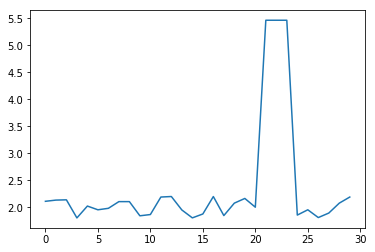

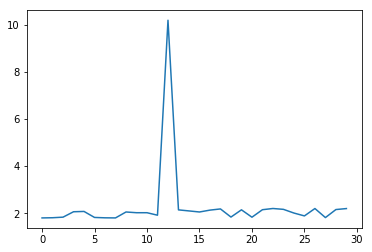

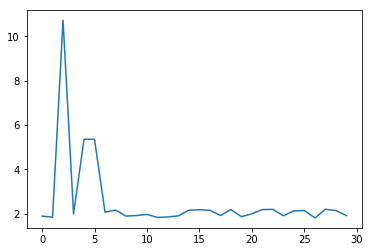

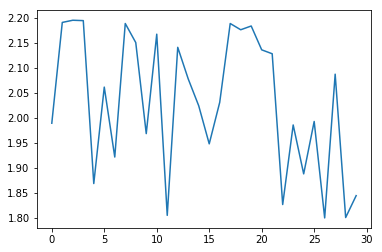

In [39]:
for n, lc in enumerate(lcs):
    if n in [1,15,25,36]:
        plt.plot(lc[0],lc[1])
        plt.show()